In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/validation/2/507/images/35.png
/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/validation/2/507/images/31.png
/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/validation/2/507/images/33.png
/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/validation/2/507/images/14.png
/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/validation/2/507/images/20.png
/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/validation/2/507/images/18.png
/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/validation/2/507/images/21.png
/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/validation/2/507/images/12.png
/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/validation/2/507/images/28.png
/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/validation/2/507/images/22.png
/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/validation/2/507/images/34.png
/kaggle/in

In [4]:
import numpy as np
np.random.seed(42) 
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

In [5]:
num_classes = len(os.listdir('/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/train'))

In [6]:
# Custom Dataset Class


class LiverDiseaseDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, _, label = self.data[idx]
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label_idx = class_names.index(label)  # Convert label to index
        return image, label_idx

# Get Class Names from Train Directory
class_names = os.listdir('/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/train')


In [7]:
train_dir = '/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/train'
training_data = []

for label in os.listdir(train_dir):
    label_dir = os.path.join(train_dir,label)
    for patient in os.listdir(label_dir):
        patient_dir = os.path.join(label_dir, patient)
        images_dir = os.path.join(patient_dir, 'images')

        for filename in os.listdir(images_dir):
            image_path = os.path.join(images_dir, filename)
            training_data.append([image_path, patient, label])

In [8]:
test_dir = '/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/test'
testing_data = []

for label in os.listdir(test_dir):
    label_dir = os.path.join(test_dir,label)
    for patient in os.listdir(label_dir):
        patient_dir = os.path.join(label_dir, patient)
        images_dir = os.path.join(patient_dir, 'images')

        for filename in os.listdir(images_dir):
            image_path = os.path.join(images_dir, filename)
            testing_data.append([image_path, patient, label])



In [9]:
valid_dir = '/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/test'
validation_data = []

for label in os.listdir(valid_dir):
    label_dir = os.path.join(test_dir,label)
    for patient in os.listdir(label_dir):
        patient_dir = os.path.join(label_dir, patient)
        valid_dir = os.path.join(patient_dir, 'images')

        for filename in os.listdir(images_dir):
            image_path = os.path.join(images_dir, filename)
            validation_data.append([image_path, patient, label])

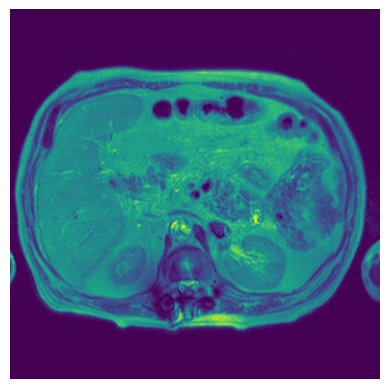

In [10]:
image_path = training_data[0][0]
image = Image.open(image_path)
plt.imshow(image)
plt.axis("off")  # Hide axes
plt.show()

In [11]:
import torchvision.transforms as transforms

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),  
        transforms.RandomRotation(degrees=5),  # Rotate image by ±5 degrees
        transforms.RandomHorizontalFlip(),  # Random horizontal flip
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}


In [12]:
train_dataset = LiverDiseaseDataset(training_data, transform=data_transforms['train'])
val_dataset = LiverDiseaseDataset(validation_data, transform=data_transforms['val'])
test_dataset = LiverDiseaseDataset(testing_data, transform=data_transforms['test'])

# Create Data Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [13]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define SelfAttention module
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, height, width = x.size()

        # Generate Q, K, V matrices
        query = self.query_conv(x).view(batch_size, -1, height * width)
        key = self.key_conv(x).view(batch_size, -1, height * width)
        value = self.value_conv(x).view(batch_size, -1, height * width)

        # Compute attention scores
        attention = torch.bmm(query.transpose(1, 2), key)
        attention = F.softmax(attention, dim=-1)

        # Compute weighted sum of value (i.e., attention output)
        out = torch.bmm(value, attention.transpose(1, 2))
        out = out.view(batch_size, C, height, width)

        # Apply gamma to the output
        out = self.gamma * out + x
        return out

# Load pre-trained ResNet-50 model
num_classes = 3
resnet50 = models.resnet50(pretrained=True)

# Modify the final fully connected layer to output 3 classes
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)

# Add self-attention module after the last residual block (layer4)
class ResNet50WithSelfAttention(nn.Module):
    def __init__(self, base_model):
        super(ResNet50WithSelfAttention, self).__init__()
        self.resnet50 = base_model
        self.attention = SelfAttention(2048)  # Channels in the last layer of ResNet-50

    def forward(self, x):
        # Pass through ResNet-50 layers
        x = self.resnet50.conv1(x)
        x = self.resnet50.bn1(x)
        x = self.resnet50.relu(x)
        x = self.resnet50.maxpool(x)

        x = self.resnet50.layer1(x)
        x = self.resnet50.layer2(x)
        x = self.resnet50.layer3(x)

        # Apply self-attention to the output of layer4
        x = self.resnet50.layer4(x)
        x = self.attention(x)  # Apply self-attention

        # Global Average Pooling and Final Fully Connected Layer
        x = self.resnet50.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.resnet50.fc(x)
        return x

# Instantiate the model with self-attention
model = ResNet50WithSelfAttention(resnet50)

# Move model to GPU if available
model = model.to(device)

# Example: Print the model architecture
print(model)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 218MB/s]


ResNet50WithSelfAttention(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Seq

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1 | train Loss: 0.8576, Acc: 0.5841
Epoch 1 | val Loss: 1.3728, Acc: 0.3643
Epoch 2 | train Loss: 0.7412, Acc: 0.6573
Epoch 2 | val Loss: 1.3777, Acc: 0.3567
Epoch 3 | train Loss: 0.6264, Acc: 0.7265
Epoch 3 | val Loss: 1.5524, Acc: 0.5161
Epoch 4 | train Loss: 0.5455, Acc: 0.7684
Epoch 4 | val Loss: 3.6368, Acc: 0.4592
Epoch 5 | train Loss: 0.4595, Acc: 0.8052
Epoch 5 | val Loss: 3.2933, Acc: 0.5161
Epoch 6 | train Loss: 0.2481, Acc: 0.9131
Epoch 6 | val Loss: 4.2154, Acc: 0.5161
Epoch 7 | train Loss: 0.1640, Acc: 0.9428
Epoch 7 | val Loss: 4.6941, Acc: 0.5161
Epoch 8 | train Loss: 0.1070, Acc: 0.9624
Epoch 8 | val Loss: 5.3480, Acc: 0.5161
Epoch 9 | train Loss: 0.0820, Acc: 0.9716
Epoch 9 | val Loss: 7.1436, Acc: 0.5161
Epoch 10 | train Loss: 0.0728, Acc: 0.9752
Epoch 10 | val Loss: 7.9043, Acc: 0.5161
Epoch 11 | train Loss: 0.0515, Acc: 0.9844
Epoch 11 | val Loss: 7.6793, Acc: 0.5161
Epoch 12 | train Loss: 0.0399, Acc: 0.9874
Epoch 12 | val Loss: 7.6332, Acc: 0.5161
Epoch 13 |

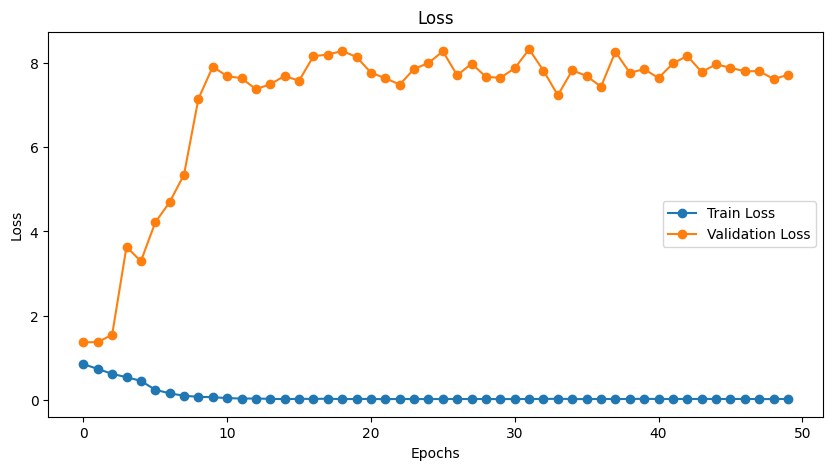

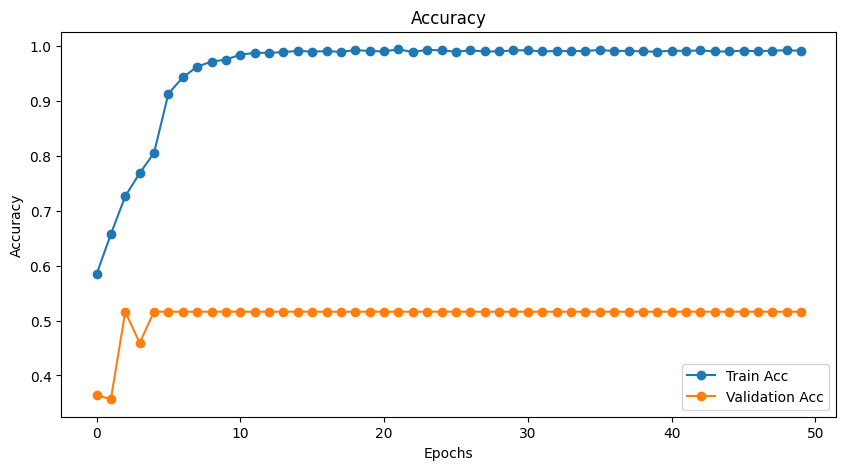

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler

# Define the scheduler (reduce LR by factor of 0.1 every 5 epochs)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

num_epochs = 50
train_losses, val_losses, train_acc, val_acc = [], [], [], []

for epoch in range(num_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
            dataloader = train_loader
        else:
            model.eval()
            dataloader = val_loader

        running_loss, correct = 0.0, 0

        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = correct / len(dataloader.dataset)

        if phase == 'train':
            train_losses.append(epoch_loss)
            train_acc.append(epoch_acc)
            scheduler.step()  # Update learning rate after each epoch
        else:
            val_losses.append(epoch_loss)
            val_acc.append(epoch_acc)

        print(f'Epoch {epoch+1} | {phase} Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs'), plt.ylabel('Loss'), plt.title('Loss'), plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Train Acc', marker='o')
plt.plot(val_acc, label='Validation Acc', marker='o')
plt.xlabel('Epochs'), plt.ylabel('Accuracy'), plt.title('Accuracy'), plt.legend()
plt.show()


In [16]:
torch.save(resnet50.state_dict(), "resnet50_model.pth")
print("Model saved successfully!")


Model saved successfully!



Overall Metrics:
Accuracy: 52.56%
Precision: 0.6046
Sensitivity (Recall): 0.5256
F1 Score: 0.5553
Specificity: 0.7917

Classification Report:
              precision    recall  f1-score   support

           2     0.1574    0.2556    0.1948       133
           3     0.5968    0.6133    0.6049       181
           1     0.7786    0.5829    0.6667       350

    accuracy                         0.5256       664
   macro avg     0.5109    0.4839    0.4888       664
weighted avg     0.6046    0.5256    0.5553       664


Specificity per Class:
2: 0.6573
3: 0.8447
1: 0.8153


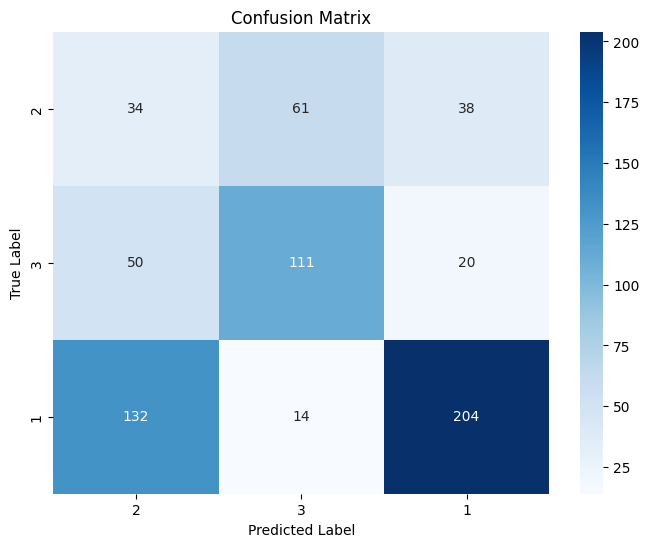

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

# Ensure model is in evaluation mode
model.eval()

# Store true and predicted labels
y_true = []
y_pred = []

# Run model on test data
with torch.no_grad():
    for inputs, labels in test_loader:  # Ensure test_loader is defined
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)  
        _, preds = torch.max(outputs, 1)  # Get class with highest probability

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Convert to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute overall metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')  # Sensitivity
f1 = f1_score(y_true, y_pred, average='weighted')

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Compute specificity per class
specificity_per_class = []
class_support = cm.sum(axis=1)  # Total samples per class
for i in range(len(class_names)):
    tn = np.sum(cm) - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])  # True Negatives
    fp = cm[:, i].sum() - cm[i, i]  # False Positives
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Avoid division by zero
    specificity_per_class.append(specificity)

# Compute overall specificity (weighted average)
overall_specificity = np.sum(np.array(specificity_per_class) * class_support) / np.sum(class_support)

# Print overall metrics
print("\nOverall Metrics:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Sensitivity (Recall): {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Specificity: {overall_specificity:.4f}")  # Overall Specificity

# Print class-wise metrics
print("\nClassification Report:")
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)

# Print specificity per class
print("\nSpecificity per Class:")
for class_name, spec in zip(class_names, specificity_per_class):
    print(f"{class_name}: {spec:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
